# Using Shutterstock's Image datasets to train your computer vision models

# Introduction

This example of multi-label classification trains the SageMaker 1P image classification algorithm. We will use the Amazon SageMaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new multi-label dataset. The pre-trained model will be fine-tuned using the [Free Sample: Images & Metadata of “Whole Foods” Shoppers dataset from Shutterstock’s Image Datasets](https://aws.amazon.com/marketplace/pp/prodview-y6xuddt42fmbu?ref_=srh_res_product_title). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

Note: This notebook is a modification of the existing [SageMaker example notebook for multi-label image classification](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_mscoco_multi_label/Image-classification-multilabel-lst.ipynb).

## Prequisites

### Step 1: Set permissions and environment variables

Here we set up the pointers and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for SageMaker training and model data
* The S3 bucket that is storing the images from the Shutterstock Image Dataset for Whole Foods Shoppers
* The SageMaker image classification docker image (which we will not need to change)

**FILL IN YOUR S3 BUCKET NAME:** For our `images_bucket` variable, replace `<enter-images-bucket-name>` with the name of the S3 bucket that contains your Shutterstock Image Dataset. If you stored your images under a prefix, please also update the `images_bucket_prefix` variable with this prefix.

In [14]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# SageMaker notebook execution role
role = get_execution_role()
print("Sagemaker Execution Role: {}".format(role))

# SageMaker S3 Bucket for training and model data
sagemaker_bucket = sagemaker.Session().default_bucket()
sagemaker_bucket_prefix = "wholefoods-ic-multilabel"
print("Using S3 Bucket for SageMaker training and model data: {}".format(sagemaker_bucket))

# SageMaker Training image for image classification
training_image = sagemaker.image_uris.retrieve(
    region=sagemaker.Session().boto_region_name, framework="image-classification", version="latest"
)
print("Using Training Image: {}".format(training_image))


images_adx_directory = "adx_free_data_sample/wholefoods/" 

# TO DO: enter the name of the S3 bucket that contains your Shutterstock Image Dataset
images_bucket = "<enter-images-bucket-name>"
# TO DO: enter the prefix (if applicable) where your images are stored, if you stored them under an additional prefix 
images_bucket_prefix = ""

print("Using S3 Bucket with Training Images: {}".format(images_bucket))

# Pointer to image metadata file
image_metadata_filename = "AWS_Wholefood Shoppers_ Metadata.csv"


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Sagemaker Execution Role: arn:aws:iam::522032406672:role/service-role/AmazonSageMaker-ExecutionRole-20210514T090761
Using S3 Bucket for SageMaker training and model data: sagemaker-us-east-2-522032406672
Using Training Image: 825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1
Using S3 Bucket with Training Images: sstk-adx-freetrial-katie


## Data Preparation

The Shutterstock Image Datasets are collections of curated images from Shutterstock’s library of more than 370 million images. You can subscribe to one of the preexisting collections, such as Food & Beverage, Clothing, or Hospitality, or you can work with the Shutterstock Data Exchange team to request a custom collection of images for your use case. Each image includes a descriptive title with up to 200 characters and an optimal 7-50 keywords. 

For this example, we use the [Free Sample: Images & Metadata of “Whole Foods” Shoppers dataset from Shutterstock’s Image Datasets](https://aws.amazon.com/marketplace/pp/prodview-y6xuddt42fmbu?ref_=srh_res_product_title) to demonstrate how to train a multi-label image classification model using Shutterstock’s prelabeled image assets. This dataset contains images of Whole Foods shoppers. Each image is tagged with 30-50 keywords describing what is seen in the image.

An image can contain objects of multiple keywords. Because the purpose of this notebook is to show how the Shutterstock dataset can be used to train for multi-label image classification, we will limit the keywords that we are training on for demonstration purposes. We have a limited set of 200 images in our free sample.

To start, we will train the model to learn to classify the first 5 keywords that appear in our dataset.

1. Adult
2. Beautiful
3. Buying
4. Car
5. Casual


The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.apache.org/versions/1.7.0/api/faq/recordio) and the other is a lst format. We will use the lst file format for training. 

### Step 2: Parse the metadata .csv file to create a .lst file for training
A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. 

The Whole Foods Shoppers dataset comes with a metadata file in CSV format. We will use this to generate our .lst file. This CSV metadata file has the following headers in the first row: 'ASSET_ID' | 'COLLECTION' |'KEYWORDS' | 'DESCRIPTION'. 



In [15]:
import numpy as np
import csv

origin_file = images_bucket_prefix + image_metadata_filename
destination_file = ("./%s" % image_metadata_filename)

s3 = boto3.resource('s3')
s3.Bucket(images_bucket).download_file(origin_file, destination_file)

# Create a dictionary (key: keyword, value: list of associated images IDs)
keyword_images = {}

# convert the metadata CSV file into a nested list
with open(destination_file, 'r', encoding='UTF-8', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

    # CSV header in Row 1 should be ['ASSET_ID, 'COLLECTION', 'KEYWORDS', 'DESCRIPTION']
    print("Data Columns: {}".format(data[0]))

    # Remove header row
    data.pop(0)

    # Map the keywords to the associated image IDs
    for row in data:
        image_id = row[0]
        image_keywords = row[2].split(',')

        for word in image_keywords:
            if word not in keyword_images:
                keyword_images[word] = []
            keyword_images[word].append(image_id)


# Train for the first 5 keywords
num_training_keywords = 5
training_keywords = list(keyword_images.keys())[0:num_training_keywords]

print("Training for the following Keywords: {}".format(training_keywords))

# obtain image ids and labels for images with these 5 classes
image_ids = []
labels = []

for index, key in enumerate(training_keywords):
    for image_id in keyword_images[key]:
        if image_id in image_ids:
            labels[image_ids.index(image_id)][index] = 1
        else:
            image_ids.append(image_id)
            labels.append(np.zeros(len(training_keywords), dtype=np.int))
            labels[-1][index] = 1

# Construct the lst file from the image ids and labels
# The first column is the image index, the last is the image filename
# and the second to last but one are the labels
with open("image.lst", "w") as fp:
    sum_labels = labels[0]
    for ind, image_id in enumerate(image_ids):
        image_path = "{}.jpg".format(image_id)
        label_h = labels[ind]
        sum_labels += label_h
        fp.write(str(ind) + "\t")
        for j in label_h:
            fp.write(str(j) + "\t")
        fp.write(image_path)
        fp.write("\n")
    fp.close()
print(sum_labels)



Data Columns: ['ASSET_ID', 'COLLECTION', 'KEYWORDS', 'DESCRIPTION']
Training for the following Keywords: ['adult', 'beautiful', 'buying', 'cart', 'casual']
[65 45 98 85 37]


### Step 3: Create the training and validation datasets
Create training and validation set by splitting the lst file. 

In [16]:
!shuf image.lst > im.lst
!head -n 100 im.lst > sstkimagestrain.lst
!tail -n +53 im.lst > sstkimagesval.lst
!head sstkimagestrain.lst
!wc -l sstkimagestrain.lst
!wc -l sstkimagesval.lst

53	1	0	1	1	0	1851287581.jpg
13	1	1	0	0	0	636775126.jpg
61	1	0	1	1	0	1917282407.jpg
6	1	0	0	1	0	373596073.jpg
11	1	0	1	0	1	608903492.jpg
105	0	0	1	0	0	1536284255.jpg
147	0	0	0	0	1	1460132606.jpg
100	0	0	1	0	1	1490982800.jpg
29	1	1	0	0	1	1621463434.jpg
89	0	0	1	0	0	242465332.jpg
100 sstkimagestrain.lst
101 sstkimagesval.lst


### Step 4: Copy the training data to your SageMaker S3 Bucket
Upload the data into the SageMaker S3 bucket. The images are uploaded under the train and validation prefixes. The lst files are uploaded under train_lst and validation_lst prefixes. 

In [17]:
# Four channels: train, validation, train_lst, and validation_lst
s3_train = "s3://{}/{}/train/".format(sagemaker_bucket, sagemaker_bucket_prefix)
s3_validation = "s3://{}/{}/validation/".format(sagemaker_bucket, sagemaker_bucket_prefix)
s3_train_lst = "s3://{}/{}/train_lst/".format(sagemaker_bucket, sagemaker_bucket_prefix)
s3_validation_lst = "s3://{}/{}/validation_lst/".format(sagemaker_bucket, sagemaker_bucket_prefix)


s3_img_source = "s3://{}/{}{}".format(images_bucket, images_bucket_prefix, images_adx_directory)


# upload the image files to train and validation channels
!aws s3 sync $s3_img_source $s3_train
!aws s3 sync $s3_img_source $s3_validation

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp sstkimagestrain.lst $s3_train_lst --quiet
!aws s3 cp sstkimagesval.lst $s3_validation_lst --quiet

## Training our Multi-Label Image Classification Model
Now that we have prepared our training data, we are ready tro train our image classification model. First, we will create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

### Step 5: Set the training parameters
There are two kinds of parameters that need to be set for training. The first are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Here, we will use ml.p2.xlarge.
* **Output path**: This the S3 folder in which the training output is stored

In [18]:
s3_output_location = "s3://{}/{}/output".format(sagemaker_bucket, sagemaker_bucket_prefix)
multilabel_ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
)

### Step 6: Set the algorithm parameters

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the dataset. We use 5 classes from MSCOCO and hence it is set to 5
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **num_training_samples**: This is the total number of training samples. It is set to 2500 for COCO dataset with the current split
* **use_weighted_loss**: This parameter is used to balance the influence of the positive and negative samples within the dataset.
* **augmentation_type**: This parameter determines the type of augmentation used for training. It can take on three values, 'crop', 'crop_color' and 'crop_color_transform'
* **precision_dtype**: The data type precision used during training. Using ``float16`` can lead to faster training with minimal drop in accuracy, paritcularly on P3 machines. By default, the parameter is set to ``float32``
* **multi_label**: Set multi_label to 1 for multi-label processing

You can find a detailed description of all the algorithm parameters at https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

In [19]:
multilabel_ic.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape="3,224,224",
    num_classes=5,
    mini_batch_size=25,
    resize=256,
    epochs=5,
    learning_rate=0.001,
    num_training_samples=100,
    use_weighted_loss=1,
    augmentation_type="crop_color_transform",
    precision_dtype="float32",
    multi_label=1,
)

### Step 7: Specify the input data 
Set the data type and channels used for training. In this training, we use application/x-image content type that require individual images and lst file for data input. 

In [20]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train,
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation,
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix",
)
train_data_lst = sagemaker.inputs.TrainingInput(
    s3_train_lst,
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix",
)
validation_data_lst = sagemaker.inputs.TrainingInput(
    s3_validation_lst,
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix",
)
data_channels = {
    "train": train_data,
    "validation": validation_data,
    "train_lst": train_data_lst,
    "validation_lst": validation_data_lst,
}

### Step 8: Train the model
Start training by calling the fit method in the estimator.

In [21]:
multilabel_ic.fit(inputs=data_channels, logs=True)

2021-06-17 18:58:01 Starting - Starting the training job...
2021-06-17 18:58:03 Starting - Launching requested ML instancesProfilerReport-1623956281: InProgress
......
2021-06-17 18:59:27 Starting - Preparing the instances for training............
2021-06-17 19:01:28 Downloading - Downloading input data...
2021-06-17 19:01:56 Training - Downloading the training image...
2021-06-17 19:02:28 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[06/17/2021 19:02:27 INFO 140493253670720] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[06/17/2021 19:02:27 

# Inference

### Step 9: Deploy the Model for Inference

Once we have trained the model, we want to use it to perform inference. In this case, we will be predicting keywords for the image. 

First, let's deploy the model. You can deploy the created model by using the deploy method in the estimator.

In [9]:
from sagemaker.serializers import IdentitySerializer

ic_classifier = multilabel_ic.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer(content_type="application/x-image"),
)

---------------!

### Step 10: Evaluate the model

Next, we evaluate one of our images through the network for inference. The network outputs probabilities for each of the keywords that we are training on. As can be seen from this example, the network output is pretty good even with training for only 5 epochs.

Training on Image File: 1721370184.jpg


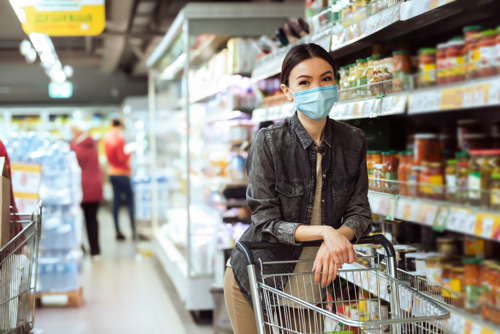

adult:0.546086 beautiful:0.086455 buying:0.899752 cart:0.969762 casual:0.437141 

In [13]:
import json
from PIL import Image


# This image was used in training. In practice, test another image that is 600x400
file_name = "1721370184.jpg"
print("Training on Image File: {}".format(file_name))

# Download and display the image
s3 = boto3.resource('s3')
s3.Bucket(images_bucket).download_file((images_adx_directory + file_name), ("./{}".format(file_name)))
with open(file_name, "rb") as image:
    f = image.read()
    b = bytearray(f)
    #display the image
    im = Image.open(image)
    im.thumbnail([500,500])
    display(im)

# Run the model prediction on the downloaded image
results = ic_classifier.predict(b)
prob = json.loads(results)
for idx, val in enumerate(training_keywords):
    print("{}:{} ".format(training_keywords[idx], prob[idx]), end="")



After running the above lines of code, our notebook will display the image and print out the probabilities of each of the keywords that we are training on. From here, we can expand the amount of keywords that we train on, fine-tune our parameters, or add additional images to further improve the accuracy of our model.


## Clean up
You can use the following command to delete the SageMaker model endpoint. The endpoint that is created above is persistent and would consume resources till it is deleted. It is good to delete the endpoint when it is not being used.

In [ ]:
ic_classifier.delete_endpoint()